## License 

Copyright 2017 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Increase Transparency and Accountability in Your Machine Learning Project with Python and H2O
#### Explain your complex models with decision tree surrogates, GBM feature importance, and reason codes

Decision trees and decision tree ensembles are some of the most popular machine learning models used in commercial practice. They can train and make predictions on data containing character values and missing values - both common in large commercial data stores. Single decision trees are easily represented as directed graphs, which can drastically increase their interpretability and transparency. Decision tree ensembles (i.e., random forests and gradient boosting machines (GBMs)), can be used to increase the accuracy and stability of single decision tree models, but are far less intepretable than single trees. These characteristics of decision trees will be leveraged here to increase transparency and accountability in complex, nonlinear, machine learning models.

This notebook starts by training a GBM on the UCI credit card default data using the popular open source library, h2o. A single decision tree *surrogate* model will then be trained on the original UCI credit card default data and the predictions from the h2o GBM, to create an approximate flow chart for the GBM's global decision-making processes. A technique known as leave-one-covariate-out (LOCO) will then be used to generate local explanations for any row-wise prediction made by the GBM model. Finally, local explanations are ensembled together from multiple similar models to increase explanation stability. 

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks. 

In [1]:
# imports

# h2o Python API with specific classes
import h2o                                        
from h2o.estimators.gbm import H2OGradientBoostingEstimator       # for GBM
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

# system packages for calling external graphviz processes
import os
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

#### Start h2o
H2o is both a library and a server. The machine learning algorithms in the library take advantage of the multithreaded and distributed architecture provided by the server to train machine learning algorithms extremely efficiently. The API for the library was imported above in cell 1, but the server still needs to be started.

In [2]:
h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()                  # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /home/owner/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp656sjmei
  JVM stdout: /tmp/tmp656sjmei/h2o_owner_started_from_python.out
  JVM stderr: /tmp/tmp656sjmei/h2o_owner_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_owner_my1g6m
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`.

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. These character values can be used directly in h2o decision tree models, and the function returns the original Pandas DataFrame as an h2o object, an H2OFrame. H2o models cannot run on Pandas DataFrames. They require H2OFrames.

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Ensure target is handled as a categorical variable

In h2o, a numeric variable can be treated as numeric or categorical. The target variable `DEFAULT_NEXT_MONTH` takes on values of `0` or `1`. To ensure this numeric variable is treated as a categorical variable, the `asfactor()` function is used to explicitly declare that it is a categorical variable. 

In [9]:
data[y] = data[y].asfactor() 

#### Display descriptive statistics
The h2o `describe()` function displays a brief description of the credit card default data. For the categorical input variables `LIMIT_BAL`, `SEX`, `EDUCATION`, `MARRIAGE`, and `PAY_0`-`PAY_6`, the new character values created above in cell 5 are visible. Basic descriptive statistics are displayed for numeric inputs. Also, it's easy to see there are no missing values in this dataset, which will be an important consideration for calculating LOCO values in section 5 and 6.

In [10]:
data[X + [y]].describe()

Rows:30000
Cols:24




,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,167484.32266666688,,,,35.48549999999994,,,,,,,51223.33090000009,49179.07516666668,47013.15479999971,43262.9489666666,40311.40096666653,38871.76039999991,5663.580500000014,5921.16350000001,5225.681500000005,4826.076866666661,4799.387633333302,5215.502566666664,
maxs,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,129747.66156720225,,,,9.21790406809016,,,,,,,73635.86057552959,71173.76878252836,69349.38742703681,64332.85613391641,60797.1557702648,59554.10753674574,16563.280354025763,23040.870402057226,17606.961469803115,15666.159744031993,15278.305679144793,17777.465775435332,
zeros,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

#### Split data into training and test sets for early stopping
The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is also an important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [11]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


#### Train h2o GBM classifier
Many tuning parameters must be specified to train a GBM using h2o. Typically a grid search would be performed to identify the best parameters for a given modeling task using the `H2OGridSearch` class. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for the h2o GBM using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `stopping_rounds` parameter is used to stop the training process after the test error fails to decrease for 5 iterations.

The `balance_classes` parameter ensures the positive and negative classes of the target variable are seen by the model in equal proportions during training. This can be very important for the LOCO calculations in section 5 and 6 for unbalanced data. From experiments across several data sets, explanations for rows with a majority class label for the target variable (e.g., 0) generated by LOCO are more likely to match those generated by another popular explanatory technique, LIME, when the target class is rebalanced during training. `balance_classes` is commented below because the row explained in this notebook has a minority class label (e.g., 1).

In [12]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     #balance_classes=True, # sample to balance 0/1 distribution of target - can help LOCO
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     seed=12345)            # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


#### Display variable importance
During training, the h2o GBM aggregates the improvement in error caused by each split in each decision tree across all the decision trees in the ensemble classifier. These values are attributed to the input variable used in each split and give an indication of the contribution each input variable makes toward the model's predictions. The variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, a customer's most recent payment behavior, `PAY_0`, is by far the most important variable followed by their second most recent payment, `PAY_2`, and third most recent payment, `PAY_3`, behavior. This result is well-aligned with business practices in credit lending: people who miss their most recent payments are likely to default soon.

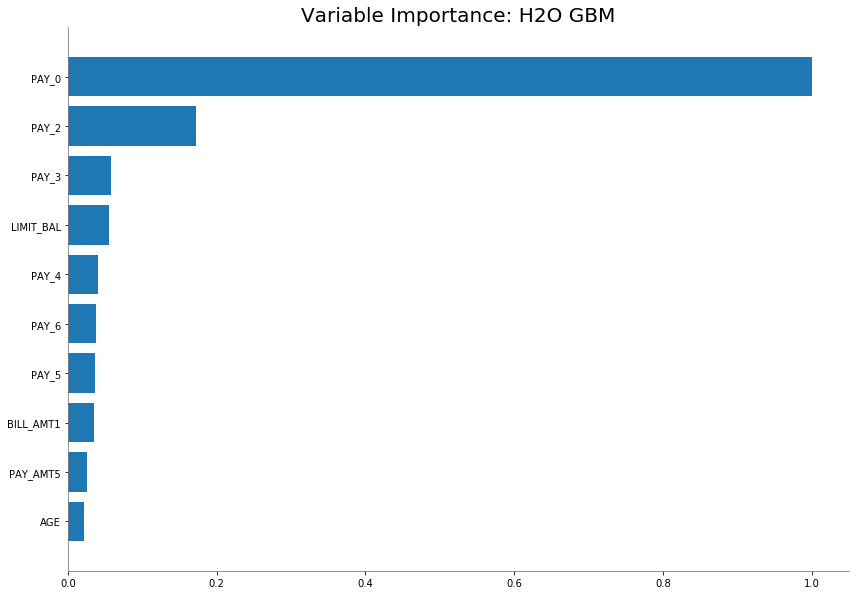

In [13]:
model.varimp_plot()

### MT Analysis  
Variable importance is based on amount (abs or percentage?) of decrease in MSE 

## 3. Train a decision tree surrogate model to describe GBM

A surrogate model is a simple model that is used to explain a complex model. One of the original references for surrogate models is available here: https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf. In this example, a single decision tree will be trained on the original inputs and predictions of the h2o GBM model and the tree will be visualized using special functionality in h2o and GraphViz. The variable importance, interactions, and decision paths displayed in the directed graph of the trained decision tree surrogate model are then assumed to be indicative of the internal mechanisms of the more complex GBM model, creating an approximate, overall flowchart for the GBM. There are few mathematical guarantees that the simple surrogate model is highly representative of the more complex GBM, but a recent preprint article has put forward ideas on strenghthening the theoretical relationship between surrogate models and more complex models: https://arxiv.org/pdf/1705.08504.pdf. Since surrogate models alone do not gaurantee accurate transparency, they will be used along with GBM variable importance and LOCO to build a cohesive narrative about the mechansims within the GBM. **Because most currently-available explanatory techniques are approximate, it is recommended that users employ several different explanatory techniques and trust only consisent results across techniques.**

### MT Analysis  
Simple model for complex model -- can be global (like this) or local like lime  
Shapley are consistent and accurate -- use them(?)  
Make decision tree so you can make plots  

**Points to remember**
1. Check performance (R2 if you look at probability comparison) 
2. Look for stability -- cross validate 
3. Check for consistency between models 

-- Wells Fargo Model Risk Group has papers  
Decision Tree with Logistic on the Nodes  
Can use neural network as surrogate model  

Can also re update the surrogate model as population changes 
This model is built on probabilities and you can keep getting probabilities  

Have used this in advertising 

Can deploy this model instead of more complex models -- (more complex model gets probabilities and then this model can build better)  

#### Create dataset for surrogate model

To train a surrogate model, the predictions and original inputs of the complex model to be explained need to be in the same dataset. The test data is used here to see how the model behaves on holdout data, which should be closer to its behavior on new data than analyzing the surrogate model for the training inputs and predictions.

In [17]:
# cbind predictions to training frame
# give them a nice name
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = test['ID'].cbind(model.predict(test).drop(['predict', 'p0']))
preds1.columns = ['ID', yhat]
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [18]:
test_yhat

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.144991
8,100000,female,university,single,23,use of revolving credit,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0.128193
10,20000,male,high school,single,35,no consumption,no consumption,no consumption,no consumption,pay duly,pay duly,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0,0.179911
16,50000,female,high school,divorced,23,1 month delay,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,0,0.325205
17,20000,male,graduate school,single,24,use of revolving credit,use of revolving credit,2 month delay,2 month delay,2 month delay,2 month delay,15376,18010,17428,18338,17905,19104,3200,0,1500,0,1650,0,1,0.408821
19,360000,female,graduate school,married,49,1 month delay,no consumption,no consumption,no consumption,no consumption,no consumption,0,0,0,0,0,0,0,0,0,0,0,0,0,0.375316
22,120000,female,university,married,39,pay duly,pay duly,pay duly,pay duly,pay duly,pay duly,316,316,316,0,632,316,316,316,0,632,316,0,1,0.226277
30,50000,male,graduate school,single,26,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,15329,16575,17496,17907,18375,11400,1500,1500,1000,1000,1600,0,0,0.146556
32,50000,male,university,single,33,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,30518,29618,22102,22734,23217,23680,1718,1500,1000,1000,1000,716,1,0.628551
37,280000,male,university,married,40,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,186503,181328,180422,170410,173901,177413,8026,8060,6300,6400,6400,6737,0,0.0875691


#### Train single h2o decision tree
A single decision tree is trained on the test  inputs and predictions. To simulate a single decision tree in h2o, the `H2ORandomForestEstimator` class is used, but only one tree is trained instead of a forest of decision trees. Setting the `mtry` parameter to `-2` tells the `H2ORandomForestEstimator` to consider all variables in all splits of a tree, instead of considering a random subset of columns. It is also recommended to set a random seed for reproducibility and to set `max_depth` to a lower number, say less than 6, so that the surrogate model will not become overly complex and hard to explain and understand. Once the tree is trained, a model optimized java object (MOJO) representation of the tree is saved. H2o provides a way to visualize the trained tree in detail using the MOJO and Graphviz.

In [19]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=3,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y=yhat, training_frame=test_yhat)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/owner/Documents/Github_projects/interpretable_machine_learning_with_python/dt_surrogate_mojo.zip


#### Create GraphViz dot file
GraphViz is an open source graph visualization tool. It is freely available from this url: http://www.graphviz.org/. To plot the trained decision tree surrogate model, a special h2o class, `PrintMojo`, is executed against the MOJO to create a GraphViz dot file representation of the tree.

In [20]:
# title for plot
title = 'Credit Card Default Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/owner/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/owner/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/owner/Documents/Github_projects/interpretable_machine_learning_with_python/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Credit Card Default Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display
Then a GraphViz command line tool is used to create a static PNG image from the dot file ... 

In [24]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


#### Display surrogate decision tree in notebook
... and the image is displayed in the notebook.

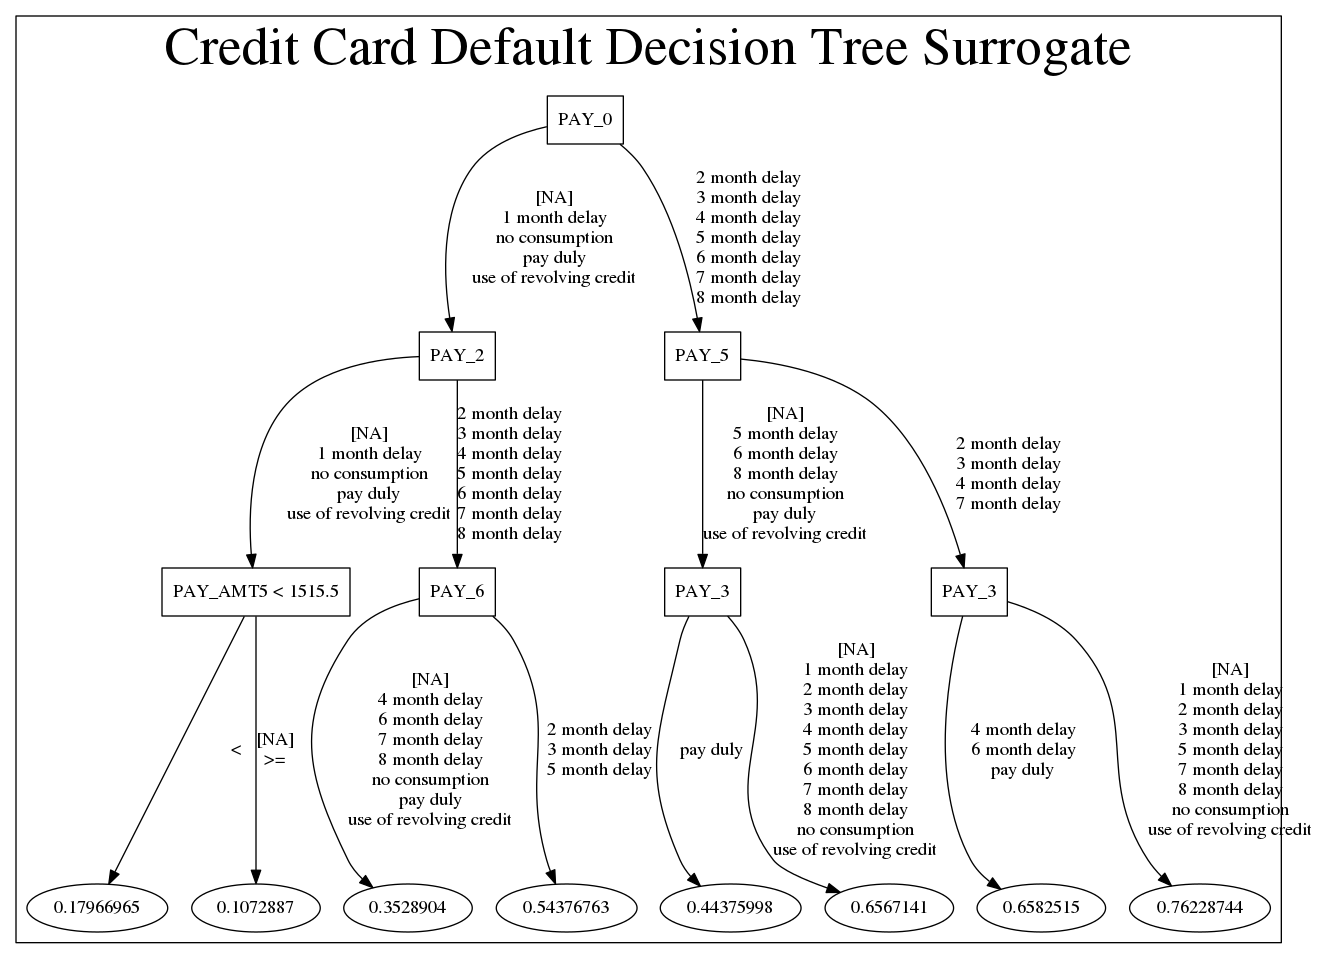

In [25]:
# display in-notebook
display(Image((png_file_name)))

## 4. Analyze surrogate model and compare to global GBM variable importance

The displayed tree is comparable with the global GBM variable importance. A simple heuristic rule for variable importance in a decision tree relates to the depth and frequency at which a variable is split on in a tree: variables used higher in the tree and more frequently in the tree are more important. Most of the variables pictured in this tree also appear as highly important in the GBM variable importance plot. In both cases, `PAY_0` is appearing as crucially important, with other payment behavior variables following close behind. The surrogate decision tree enables users to understand and confirm not only what input variables are important, but also how their values contribute to model decisions. For instance, to fall into the lowest probability of default leaf node in the surrogate decision tree a customer must make their first and second payments in a timely fashion and then pay more than 1515.5 New Tiawanese Dollars for their fifth payment. Conversely, customers who miss their first, fifth, and third payments fall into the highest probability of default leaf node of the surrogate decision tree. It is also imperative to compare these results to domain knowledge and reasonable expectations. In this case, the global explanatory methods applied thus far tell a consisent and reasonable story about the GBM's behavior. If this was not so, steps should be taken to either reconcile or remove inconsistencies and unreasonable prediction behavior.

## 5. Generate reason codes using the LOCO method 

Now that a solid understanding of global model behavior has been attained, local behavior for any given row of data and prediction can be analyzed and validated using LOCO. The LOCO method presented here is adapted from *Distribution-Free Predictive Inference for Regression* by Jing Lei et al., http://www.stat.cmu.edu/~ryantibs/papers/conformal.pdf. Here the local contribution of an input variable to a prediction for a single row of data is estimated by rescoring the GBM on that row one time for each input variable, each time leaving out one input variable (e.g., "covariate") by setting it to missing, and then subtracting the new score from the original score. By default, h2o scores missing data in decision trees by running them through the majority decision path. This means LOCO will be a numeric measure of how different the local contribution of an input variable is from the most common local contribution of that variable in the model. This variant of LOCO differs from the original method, in which one input variable is dropped from the model and the model is retrained without that variable. For nonlinear models, nonlinear dependencies can allow variables to nearly completely replace one another when a variable is dropped and the model is retrained. Hence, the approach of injecting missing values is used to estimate local contributions of input variables for nonlinear models here, as opposed to dropping a variable and retraining the model.

#### Calculate LOCO reason values for each row of the test set
To implement LOCO, GBM model predicitions are calculated once for the test data and then again for each input variable, setting the entire input variable column to missing. Once the prediction without the variable is found for every row of data in the test set, that column vector of predictions on corrupted data can be subtracted from the column vector of predictions on the original, non-corrupted data to estimate the local contribution of that variable for each prediction in the test data. For better local accuracy and explainability, LOCO contributions are scaled such that contributions for each prediction plus the overall average of `DEFAULT_NEXT_MONTH` always sum to the model predictions.

In [26]:
h2o.no_progress() # turn off h2o gratuitous progress bars

# create set of original predictions and row ID
preds2 = test['ID'].cbind(model.predict(test).drop(['predict', 'p0']))
preds2.columns = ['ID', yhat]

# calculate LOCO for each variable
print('Calculating LOCO contributions ...')
for k, i in enumerate(X):

    # train and predict with x_i set to missing
    test_loco = h2o.deep_copy(test, 'test_loco')
    test_loco[i] = np.nan
    preds_loco = model.predict(test_loco).drop(['predict','p0'])
    
    # create a new, named column for the LOCO prediction
    preds_loco.columns = [i]
    preds2 = preds2.cbind(preds_loco)
    
    # subtract the LOCO prediction from the original prediction
    preds2[i] = preds2[yhat] - preds2[i]
    
    # update progress
    print('LOCO Progress: ' + i + ' (' + str(k+1) + '/' + str(len(X)) + ') ...')
    
# scale contributions to sum to yhat - y_0
print('\nScaling contributions ...')

y_0 = test[y].mean()[0]
preds2_pd = preds2.as_data_frame()
pred_ = preds2_pd[yhat]
scaler = (pred_ - y_0) / preds2_pd[X].sum(axis=1)
preds2_pd[X] = preds2_pd[X].multiply(scaler, axis=0)   

print('Done.')  

preds2_pd.head()

Calculating LOCO contributions ...
LOCO Progress: LIMIT_BAL (1/23) ...
LOCO Progress: SEX (2/23) ...
LOCO Progress: EDUCATION (3/23) ...
LOCO Progress: MARRIAGE (4/23) ...
LOCO Progress: AGE (5/23) ...
LOCO Progress: PAY_0 (6/23) ...
LOCO Progress: PAY_2 (7/23) ...
LOCO Progress: PAY_3 (8/23) ...
LOCO Progress: PAY_4 (9/23) ...
LOCO Progress: PAY_5 (10/23) ...
LOCO Progress: PAY_6 (11/23) ...
LOCO Progress: BILL_AMT1 (12/23) ...
LOCO Progress: BILL_AMT2 (13/23) ...
LOCO Progress: BILL_AMT3 (14/23) ...
LOCO Progress: BILL_AMT4 (15/23) ...
LOCO Progress: BILL_AMT5 (16/23) ...
LOCO Progress: BILL_AMT6 (17/23) ...
LOCO Progress: PAY_AMT1 (18/23) ...
LOCO Progress: PAY_AMT2 (19/23) ...
LOCO Progress: PAY_AMT3 (20/23) ...
LOCO Progress: PAY_AMT4 (21/23) ...
LOCO Progress: PAY_AMT5 (22/23) ...
LOCO Progress: PAY_AMT6 (23/23) ...

Scaling contributions ...
Done.


,ID,p_DEFAULT_NEXT_MONTH,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,4,0.144991,-0.079758,-0.000000,-0.00000,-0.009143,-0.001728,-0.000000,-0.000000,-0.000000,...,-0.002113,0.005768,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.005340
1,8,0.128193,-0.020007,-0.000000,-0.00000,-0.000000,-0.000000,0.011403,-0.000000,0.045036,...,0.010062,-0.000000,-0.059467,0.015406,-0.028304,-0.036129,-0.067713,-0.000000,0.057314,-0.000000
2,10,0.179911,-0.024094,-0.002945,-0.00000,-0.000000,-0.009850,0.003778,-0.000000,0.005310,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.005015,-0.003077,-0.009657,0.019491,-0.000000,-0.004973
3,16,0.325205,0.012617,0.000000,0.00000,0.004043,0.000000,0.027090,0.055267,0.000000,...,0.000000,-0.003265,0.000000,0.000000,0.005403,0.000000,0.000000,0.000000,0.000000,0.000000
4,17,0.408821,0.033188,0.000000,0.00186,0.000000,0.000000,0.000000,0.000000,0.051523,...,-0.001966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001247,0.000000,0.008397


### MT Analysis 
Paypal does this...  

set one column to missing and subtract value of predictions  ( can also impute if model doesn't support missing) 
You will get a very different model if you leave one column out,  


This is cheap, Not consistent like shapley and shapley takes longer per observation  



The numeric LOCO values in each column are an estimate of how much each variable contributed to each prediction. LOCO can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from LOCO local variable contribution values by simply ranking the variables that played the largest role in any given decision.

#### Helper function for finding percentile indices
The function below finds and returns the row indices for the minimum, the maximum, and the deciles of one column in terms of another, in this case the model predictions (`p_DEFAULT_NEXT_MONTH`) and the row identifier (`ID`), respectively. These indices are used as a starting point for finding potentially interesting predictions. Outlying predictions found through residual analysis is another group of potentially interesting local predictions to analyze with LOCO.

In [27]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the minimum, maximum, and percentiles of a column, yhat, 
        as the indices based on another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: H2OFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # convert to Pandas and sort 
    sort_df = preds2_pd.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]
    inc = sort_df.shape[0]//10
    
    # find 10th-90th percentiles    
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict = get_percentile_dict(yhat, 'ID', preds2_pd)
percentile_dict

{0: 28716,
 99: 29116,
 10: 8942,
 20: 28257,
 30: 4074,
 40: 13411,
 50: 16633,
 60: 2402,
 70: 19769,
 80: 25069,
 90: 21372}

#### Plot some reason codes for a risky customer
Investigating customers with very high or low predicted probabilities to determine if their local explanations justify their extreme predictions is typically a productive exercise in boundary testing, model debugging, and validation. Reason codes are generated for the customer with the highest probability of default in the test data set below in cell 18, but LOCO can create local explanations for any or all rows in the training or test datasets, and on new data.

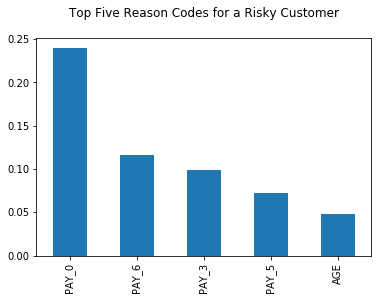

In [28]:
# select single customer
# convert to Pandas
# drop prediction and row ID

risky_loco = preds2_pd[preds2_pd['ID'] == int(percentile_dict[99])].drop(['ID', yhat], axis=1)   

# transpose into column vector and sort        
risky_loco = risky_loco.T.sort_values(by=8674, ascending=False)[:5]

# plot
_ = risky_loco.plot(kind='bar', 
                    title='Top Five Reason Codes for a Risky Customer\n', 
                    legend=False)

For the customer in the test dataset that the GBM predicts as most likely to default, the most important input variables in the prediction are, in descending order, `PAY_0`, `PAY_6`, `PAY_3`, `PAY_5`, and `AGE`.

#### Display customer in question 

The local contributions for this customer appear reasonable, especially when considering her payment information. Her most recent payment was 3 months late and her payment for 6 months previous was 4 months late, so it's logical that these would weigh heavily into the model's prediction for default for this customer.

In [29]:
test_yhat[test_yhat['ID'] == int(percentile_dict[99]), :] # helps understand reason codes

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
29116,20000,female,university,married,59,3 month delay,2 month delay,3 month delay,2 month delay,2 month delay,4 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1,0.895285


To generate reason codes for the model's decision, the locally important variable and its value are used together. If this customer was denied future credit based on this model and data, the top five LOCO-based reason codes for the automated decision would be:

1. Most recent payment is 3 months delayed.
2. 6th most recent payment is 4 months delayed.
3. 3rd most recent payment is 3 months delayed.
4. 5th most recent payment is 2 months delayed.
5. Customer age is 59. 

(Of course, in many places, variables like `AGE` and `SEX` cannot be used in credit lending decisions.)

## 6. Bonus: Generate ensemble LOCO reason codes for greater explanation stability
Just like predictions from high variance, nonlinear models, *explanations* derived from machine learning models can be unstable. One general way to decrease variance is to ensemble the results of many models. The last section of this notebook puts forward a simple approach to creating ensemble explanations.

#### Train multiple models
To create ensemble explanations, several accurate models are trained. The models and their predictions on the test data are stored in Python lists.

In [30]:
n_models = 10 # select number of models

# lists for holding models and predictions
models = []
pred_frames = []

for i in range(0, n_models):

    # initialize and store models
    models.append(H2OGradientBoostingEstimator(ntrees=150,
                                               max_depth=4,
                                               sample_rate=0.9 - ((i + 1)*0.01),     # perturb sample rate
                                               col_sample_rate=0.9 - ((i + 1)*0.01), # perturb column sample rate
                                               #balance_classes=True,                # sample to balance 0/1 distribution of target - helps LOCO
                                               stopping_rounds=5,                    # stop if validation error does not decrease for 5 iterations (trees)
                                               seed=i + 1))                          # new random seed for each model
    
    # train models
    models[i].train(y=y, x=X, training_frame=train, validation_frame=test)
    
    # store predictions
    pred_frames.append(test['ID'].cbind(models[i].predict(test).drop(['predict','p0'])))
    pred_frames[i].columns = ['ID', yhat]
    
    # update progress
    print('Training Progress: model %d/%d, AUC = %.4f ...' % (i + 1, n_models, models[i].auc(valid=True)))

print('Done.')

Training Progress: model 1/10, AUC = 0.7813 ...
Training Progress: model 2/10, AUC = 0.7803 ...
Training Progress: model 3/10, AUC = 0.7787 ...
Training Progress: model 4/10, AUC = 0.7826 ...
Training Progress: model 5/10, AUC = 0.7804 ...
Training Progress: model 6/10, AUC = 0.7800 ...
Training Progress: model 7/10, AUC = 0.7802 ...
Training Progress: model 8/10, AUC = 0.7799 ...
Training Progress: model 9/10, AUC = 0.7796 ...
Training Progress: model 10/10, AUC = 0.7811 ...
Done.


#### Calculate LOCO for each model
LOCO is calculated on the test data for each model, each input, and each row of data in the test set using the stored models and predictions.

In [32]:
# for each new model ...
for k, model in enumerate(models):

    # calculate LOCO for each input variable 
    for i in X:

        # train and predict with Xi set to missing
        test_loco = h2o.deep_copy(test, 'test_loco')
        test_loco[i] = np.nan
        preds_loco = model.predict(test_loco).drop(['predict','p0'])

        # create a new, named column for the LOCO prediction
        preds_loco.columns = [i]
        pred_frames[k] = pred_frames[k].cbind(preds_loco)

        # subtract the LOCO prediction from the original prediction
        pred_frames[k][i] = pred_frames[k][yhat] - pred_frames[k][i]
        
    # update progress    
    print('LOCO Progress: model %d/%d ...' % (k + 1, n_models))

print('Done.')

LOCO Progress: model 1/10 ...
LOCO Progress: model 2/10 ...
LOCO Progress: model 3/10 ...
LOCO Progress: model 4/10 ...
LOCO Progress: model 5/10 ...
LOCO Progress: model 6/10 ...
LOCO Progress: model 7/10 ...
LOCO Progress: model 8/10 ...
LOCO Progress: model 9/10 ...
LOCO Progress: model 10/10 ...
Done.


#### Collect LOCO values for each model for a risky customer
To create ensemble explanations for a single row, the LOCO values for each variable in the row are averaged across all models. Single-model and mean LOCO values for the most risky person in the test set are displayed below. Notice that even slight changes in model specifications can result in different explanations. For example, the local contribution of `PAY_0` for the riskiest customer ranges from 0.13 to 0.23 across the 10 models in the table below. 

In [34]:
# holds predictions for a specific row 
risky_loco_frames = []

# column names for Pandas DataFrame of combined LOCO prediction
col_names = ['Loco ' + str(i) for i in range(1, n_models + 1)]

# for each new model ...
for i in range(0, n_models):
    
    # collect LOCO for that model and a specific row 
    # as a column vector in a Pandas DataFrame
    preds = pred_frames[i]
    risky_loco_frames.append(preds[preds['ID'] == int(percentile_dict[99]), :] # row for risky person
                             .as_data_frame()                                  # convert to Pandas
                             .drop(['ID', yhat], axis=1)                       # drop predictions and row ID
                             .T)                                               # Transpose into column vector

# bind LOCO for each row as column vectors 
# into the same Pandas DataFrame
loco_ensemble = pd.concat(risky_loco_frames, axis=1) 

# update column names
loco_ensemble.columns = col_names

# mean local importance across models
loco_ensemble['Mean Local Importance'] = loco_ensemble.mean(axis=1)

# scale contribs
scaler = (test_yhat[test_yhat['ID'] == int(percentile_dict[99]), yhat] - y_0) /\
    (loco_ensemble['Mean Local Importance'].sum())
loco_ensemble['Scaled Mean Local Importance'] = loco_ensemble['Mean Local Importance'] * scaler[0, 0]

# std deviation
loco_ensemble['Std. Dev. Local Importance'] = loco_ensemble\
                                              .drop('Scaled Mean Local Importance', axis=1)\
                                              .std(axis=1)
        
# display
loco_ensemble

,Loco 1,Loco 2,Loco 3,Loco 4,Loco 5,Loco 6,Loco 7,Loco 8,Loco 9,Loco 10,Mean Local Importance,Scaled Mean Local Importance,Std. Dev. Local Importance
AGE,0.871587,0.813006,0.015365,0.019450,0.047277,0.008411,0.019311,0.019194,0.064969,0.047981,0.192655,0.005553,0.325526
AGE0,0.871587,0.813006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.842297,0.024278,0.029291
BILL_AMT1,0.893300,0.036190,0.002133,0.025375,0.001071,0.004628,0.018029,0.004658,0.021524,0.027100,0.103401,0.002980,0.263551
BILL_AMT10,0.893300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.893300,0.025748,0.000000
BILL_AMT2,0.885429,0.001631,0.000000,0.000000,0.031767,0.000000,0.008615,0.000000,0.000000,0.000000,0.092744,0.002673,0.264397
BILL_AMT20,0.885429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.885429,0.025521,0.000000
BILL_AMT3,0.894233,-0.001008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001648,0.000000,0.089158,0.002570,0.268359
BILL_AMT30,0.894233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894233,0.025775,0.000000
BILL_AMT4,0.895603,0.000000,0.000000,0.000000,0.000000,-0.010070,0.000000,-0.005586,0.000000,-0.001738,0.087821,0.002531,0.269280
BILL_AMT40,0.895603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.895603,0.025815,0.000000


#### Plot some mean reason codes for a risky customer
Taking mean explanations across multiple models leads to reason codes somewhat different from the reason codes produced by a single model. Mean reason codes may be more stable, they represent explanations from several models, and they may take practicioners a step closer to using machine learning models to make inferential conclusions about phenomena represented in the training or test data, instead of simply providing an approximate explanation of a single model's decision processes. 

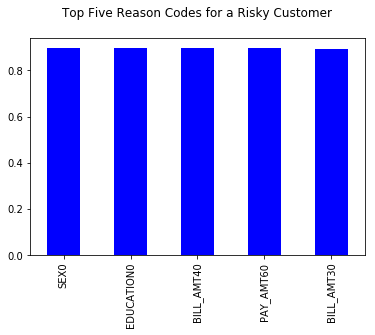

In [35]:
risky_mean_loco = loco_ensemble['Mean Local Importance'].sort_values(ascending=False)[:5]
_ = risky_mean_loco.plot(kind='bar', 
                         title='Top Five Reason Codes for a Risky Customer\n', 
                         color='b',
                         legend=False)

#### Shutdown H2O
After using h2o, it's typically best to shut it down. However, before doing so, users should ensure that they have saved any h2o data structures, such as models and H2OFrames, or scoring artifacts, such as POJOs and MOJOs.

In [36]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8221 closed.


#### Summary

In this notebook, a complex GBM classifier was trained to predict credit card defaults and explained at a global scale with a decision tree surrogate model and explained at a local scale with LOCO. An ensemble LOCO approach was also introduced to stabilize approximate explanations. The decision tree surrogate creates an overall approximate flowchart for the GBM's decision processes and LOCO can be used to create reason codes for each model prediction. All of these techniques enhance the transparency of the complex model, which in turn enables greater accountability for the model's predictions. These techniques should generalize well for many types of business and research problems, enabling you to train a complex GBM model and explain it to your colleagues, bosses, and potentially, external regulators. 